In [0]:
import warnings
warnings.filterwarnings('ignore')

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Lesson 4*
On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophiscated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifing common themes in customer reviews
* Discoverying the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* <a href="#p1">Part 1</a>: Describe how an LDA Model words
* <a href="#p2">Part 2</a>: Estimate a LDA Model with Gensim
* <a href="#p3">Part 3</a>: Interpret LDA results
* <a href="#p4">Part 4</a>: Select the appropriate number of topics

## Part 1: Latent Dirchilet Allocation (LDA) Models
<a id="#p1"></a>

LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Part 2: Estimating LDA Models with Gensim
<a id="#p1"></a>

### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [0]:
!pip install pyldavis

In [0]:
import numpy as np
import gensim
import os
import re

from gensim.utils import smart_open, simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

lettier.com/projects/lda-topic-modeling

* alpha: control part of the distribution across topics(set between 1 and 0)
* beta: control across documents (set between 1 and 0)
* iterations:





In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [0]:
path = '/content/drive/My Drive/austen-bront%C3%AB-split'

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [0]:
titles = [t[:-4] for t in os.listdir(path)]

In [0]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [9]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

### Author DataFrame


In [0]:
df = pd.DataFrame(index=titles)

In [11]:
df.head()

""
Austen_Emma0000
Austen_Emma0003
Austen_Emma0006
Austen_Emma0001
Austen_Emma0002


In [0]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [0]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [14]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

In [15]:
df.head()

,author,book,section
Austen_Emma0000,1,Emma,0
Austen_Emma0003,1,Emma,3
Austen_Emma0006,1,Emma,6
Austen_Emma0001,1,Emma,1
Austen_Emma0002,1,Emma,2


### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [0]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            tokens = tokenize(str(text))
            yield tokens

### Gensim LDA Topic Modeling

In [0]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [18]:
id2word.doc2bow(tokenize('This is a sample message Darcy England England England'))

[(2580, 1), (3848, 3), (6607, 1), (6776, 1)]

In [19]:
id2word.token2id['england']

3848

In [0]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=10, no_above=0.75)#toss out less than ten times and more than 75% of a doc

In [0]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [0]:
corpus[0]#(doc number,times word appears)

In [0]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,#needed
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=4#num cores, -1 isn't as good
                  )

In [0]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [0]:
topics = [' '.join(t[2:5]) for t in words]

In [26]:
print(topics)

['dixon fairfax know', 'eshton ladies miss', 'think know thing', 'think know miss', 'edward sister dashwood', 'heart like think', 'dr dress john', 'face sir shall', 'miss elton knightley', 'lady young john', 'jane bennet bingley', 'miss gateshead georgiana', 'long thought room', 'like english thought', 'like papa john']


## Part 3: Interpret LDA Results
<a id="#p3"></a>

### Topic Distance Visualization

In [0]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [28]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.102147  0.005061       1        1  14.242978
10    -0.110629 -0.009555       2        1  13.751936
13     0.091512 -0.041130       3        1  13.369444
2     -0.139377 -0.002774       4        1  12.019068
4     -0.114923 -0.035977       5        1  11.447495
7      0.056511  0.009278       6        1  10.571412
8     -0.103483 -0.005832       7        1   6.953409
14     0.063232 -0.016198       8        1   5.608888
9     -0.027051 -0.010214       9        1   5.118182
5      0.077127 -0.066140      10        1   2.320206
3      0.000679 -0.023738      11        1   1.904550
1      0.042615  0.010777      12        1   1.075438
11     0.037168  0.205550      13        1   0.663776
6      0.100738 -0.040396      14        1   0.506775
0     -0.076266  0.021287      15        1   0.446442, topic_info=     Category         Freq        Term        Total  loglift  logprob
170   Default  1508.000000        miss  1508.000000  30.0000  30.0000
81    Default   840.000000        emma   840.000000  29.0000  29.0000
139   Default   928.000000        jane   928.000000  28.0000  28.0000
4177  Default   706.000000      elinor   706.000000  27.0000  27.0000
1144  Default   641.000000   elizabeth   641.000000  26.0000  26.0000
4183  Default   582.000000    marianne   582.000000  25.0000  25.0000
721   Default  1332.000000        like  1332.000000  24.0000  24.0000
559   Default   510.000000     harriet   510.000000  23.0000  23.0000
757   Default   590.000000         sir   590.000000  22.0000  22.0000
718   Default  1426.000000        know  1426.000000  21.0000  21.0000
3728  Default   417.000000      madame   417.000000  20.0000  20.0000
260   Default  1304.000000       think  1304.000000  19.0000  19.0000
2109  Default   370.000000     fairfax   370.000000  18.0000  18.0000
4662  Default   361.000000   rochester   361.000000  17.0000  17.0000
799   Default   376.000000       elton   376.000000  16.0000  16.0000
3794  Default   413.000000       darcy   413.000000  15.0000  15.0000
278   Default   427.000000      weston   427.000000  14.0000  14.0000
4265  Default   372.000000        lucy   372.000000  13.0000  13.0000
1370  Default   618.000000        john   618.000000  12.0000  12.0000
261   Default  1142.000000     thought  1142.000000  11.0000  11.0000
717   Default   378.000000   knightley   378.000000  10.0000  10.0000
147   Default   583.000000        life   583.000000   9.0000   9.0000
2305  Default   305.000000     colonel   305.000000   8.0000   8.0000
258   Default   783.000000       thing   783.000000   7.0000   7.0000
4366  Default   126.000000      bessie   126.000000   6.0000   6.0000
3776  Default   321.000000      bennet   321.000000   5.0000   5.0000
152   Default   944.000000        long   944.000000   4.0000   4.0000
4899  Default   232.000000     bretton   232.000000   3.0000   3.0000
198   Default   387.000000        poor   387.000000   2.0000   2.0000
4379  Default   127.000000        reed   127.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
2822  Topic15     4.298694  instrument    56.062634   2.8435  -5.6966
654   Topic15     3.047559       agree    41.653801   2.7966  -6.0406
1350  Topic15     1.848372   dependent    25.030445   2.8058  -6.5406
1580  Topic15     5.429793       music    91.790749   2.5840  -5.4630
2109  Topic15    10.489420     fairfax   370.062805   1.8483  -4.8045
406   Topic15     3.815154       perry    77.388123   2.4018  -5.8159
1123  Topic15     7.526344         air   266.077942   1.8462  -5.1365
2305  Topic15     7.753294     colonel   305.784729   1.7369  -5.1068
139   Topic15    11.494457        jane   928.794678   1.0196  -4.7130
757   Topic15     9.047676         sir   590.169556   1.2337  -4.9524
57    Topic15     5.341101    daughter   273.709717   1.4750  -5.4795
147   Topic15     7.277487   

### Overall Model / Documents

In [0]:
distro = [lda[d] for d in corpus]

In [30]:
distro[0]

[(2, 0.7539251), (4, 0.21143597), (12, 0.032658793)]

In [0]:
def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [0]:
d_dist = {k:0 for k in range (0,15)}

In [0]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics

In [34]:
df.head()

,dixon fairfax know,eshton ladies miss,think know thing,think know miss,edward sister dashwood,heart like think,dr dress john,face sir shall,miss elton knightley,lady young john,jane bennet bingley,miss gateshead georgiana,long thought room,like english thought,like papa john
Austen_Emma0000,0.0,0.0,0.753925,0.0,0.211436,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.032659,0.0,0.0
Austen_Emma0003,0.0,0.0,0.827130,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.170534,0.0,0.000000,0.0,0.0
Austen_Emma0006,0.0,0.0,0.214257,0.0,0.000000,0.0,0.0,0.0,0.783432,0.0,0.000000,0.0,0.000000,0.0,0.0
Austen_Emma0001,0.0,0.0,0.997247,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
Austen_Emma0002,0.0,0.0,0.997422,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


## Part 4: Selecting the Number of Topics
<a id="#p4"></a>

In [0]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        stream = doc_stream(path)
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=stream, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=path, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

In [0]:
import matplotlib.pyplot as plt

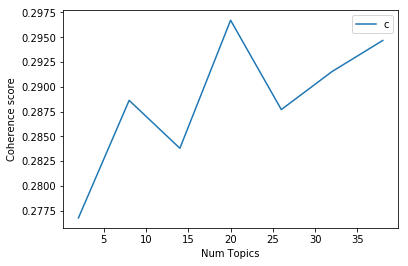

In [39]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2768
Num Topics = 8  has Coherence Value of 0.2886
Num Topics = 14  has Coherence Value of 0.2838
Num Topics = 20  has Coherence Value of 0.2967
Num Topics = 26  has Coherence Value of 0.2877
Num Topics = 32  has Coherence Value of 0.2915
Num Topics = 38  has Coherence Value of 0.2947


## Additional Resources
## Resources

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)